# Testing `pycic`

In [1]:
import numpy as np
import pycic

import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Cosmology Object

Class `Cosmology` is used to store a cosmology model, which can be used for calculating linear power spectrum, $E(z)$, growth factor and rate etc. 

In [2]:
# create a linear power spectrum object from power spectrum data:
# cosmology: h = 0.7, Om0 = 0.3, Ob0 = 0.05 Tcmb0 = 2.725, ns = 1.
# k range: 1e-8 to 1e+8
# file struct.: ln(k), ln(pk_unnorm)
pk_tab = np.loadtxt("./data/power.csv", delimiter = ',')

c = pycic.Cosmology(Om0 = 0.3, Ode0 = 0.7, h = 0.7, ns = 1., pk_tab = pk_tab)

# normalize the power with sigma8 = 0.8
c.normalisePower(0.8)
c.var(8.)

0.6400000000000001

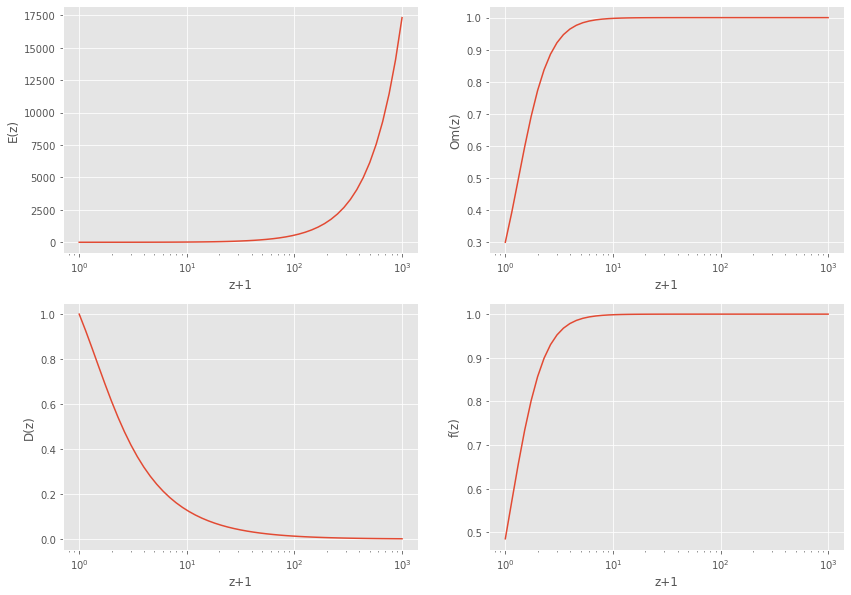

In [3]:
# some useful functions of redshift z

zp1 = np.logspace(0, 3, 51)

fzs = {
            'E' : c.Ez(zp1-1),  # E(z) = H(z) / H0
            'Om': c.Omz(zp1-1), # matter density parameter
            'D' : c.Dz(zp1-1),  # linear growth factor
            'f' : c.fz(zp1-1),  # linear growth rate, ~ Omz^0.6
      }


fig, axs = plt.subplots(2, 2, figsize = (14, 10))

for _axi, _fz, _name in zip(axs.flatten(), fzs.values(), fzs.keys()):
    _axi.semilogx(zp1, _fz, '-', )
    _axi.set_xlabel('z+1'); _axi.set_ylabel(_name + '(z)')

plt.show()

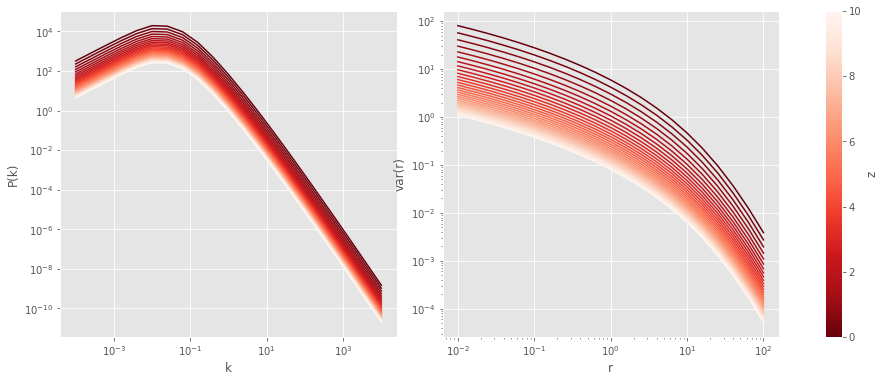

In [4]:
# power spectrum:

k  = np.logspace(-4, 4, 21)
r  = np.logspace(-2, 2, 21)
zs = np.linspace(0., 10., 31)

# creating a colormap
from matplotlib import colors, cm 
cmap = cm.ScalarMappable(
                            norm = colors.Normalize(zs.min(), zs.max(), ),
                            cmap = cm.Reds_r
                        )
cmap.set_array([])

fig, (ax1, ax2, cax) = plt.subplots(1, 3, figsize = (14, 6), 
                                    gridspec_kw = {"width_ratios":[1, 1, 0.05]})

ax1.loglog(); ax2.loglog()
for z in zs:
    ax1.plot(k, c.power(k, z), '-', color = cmap.to_rgba(z))

    # `var` is not a vector function - vectorizing using `map` (slow)
    ax2.plot(r, np.asarray(list(map(lambda r: c.var(r, z), r))), '-', color = cmap.to_rgba(z))
ax1.set_xlabel('k'); ax1.set_ylabel('P(k)')
ax2.set_xlabel('r'); ax2.set_ylabel('var(r)')

plt.colorbar(cmap, cax = cax, orientation = "vertical")
cax.set_ylabel('z')

plt.show()

## One-Point GEV Distribution

One point distribution function for $\delta$ implemented in `pycic` is the function given in Repp & Szapudi 2018 (arXiv:1705.08015v2). For the log field $A = \log(\delta+1)$, it is given by

$$ \mathcal{P}(A) = \frac{1}{\sigma} t(A)^{1 + \xi} \exp[-t(A)] $$

where

$$ t(A) = \left( 1 + \frac{A - \mu}{\sigma} \xi \right)^{-1/\xi} $$

$\mu, \sigma, \xi$ are the location, scale and shape parameters. 

In [5]:
pdf = pycic.DeltaDistribution(0., 1.95, c)

cell variance:  5.401181186241417


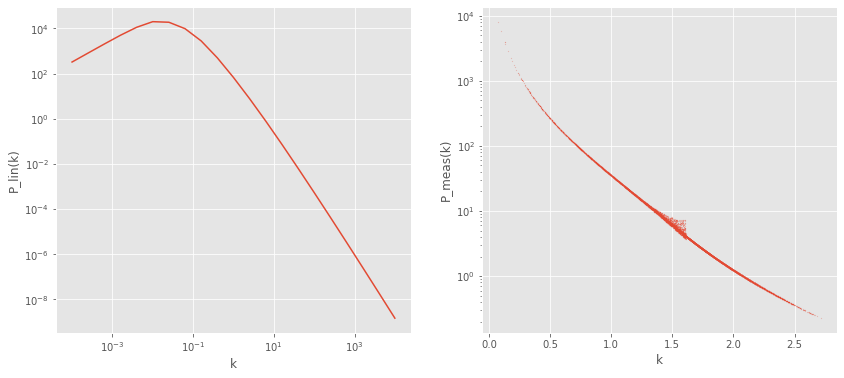

In [6]:
# power and cell variance:
print("cell variance: ", pdf.linvar())

k  = np.logspace(-4, 4, 21)
pk = pdf.linpower(k) # linear power

kx, ky, kz = np.random.uniform(-pdf.kn, pdf.kn, (10000, 3)).T
mpk = pdf.measpower(kx, ky, kz) # measured power

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6), )

ax1.loglog()
ax1.plot(k, pk, '-')
ax1.set_xlabel('k'); ax1.set_ylabel('P_lin(k)')

ax2.semilogy()
ax2.plot(np.sqrt(kx**2 + ky**2 + kz**2), mpk, 'o', ms = 0.1)
ax2.set_xlabel('k'); ax2.set_ylabel('P_meas(k)')

plt.show()